<div style="background-color:black;
            color:white;
            transform:skew(-20deg);
            padding:30px;
            font-family:Verdana;
            letter-spacing:1px;
            margin:auto;
            width:fit-content;">
    <h2 style="transform:skew(20deg); margin:0;">Import Needed Libraries</h2>
</div>

In [1]:
import os
import cv2
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import tensorflow as tf 
import keras 
from sklearn.metrics import confusion_matrix , classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

<div style="background-color:black;
            color:white;
            transform:skew(-20deg);
            padding:30px;
            font-family:Verdana;
            letter-spacing:1px;
            margin:auto;
            width:fit-content;">
    <h2 style="transform:skew(20deg); margin:0;">Reading Dataset And Get Info</h2>
</div>

In [3]:
Class_Names = os.listdir('/kaggle/input/skin-issues-version-2-dataset-balanced/Skin v2')
Class_Names_dict = {name: idx for idx, name in enumerate(Class_Names)}
print("Class Mapping:", Class_Names_dict)

IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32
CHANNELS = 3

Class Mapping: {'acne': 0, 'dark spots': 1, 'wrinkles': 2, 'pores': 3, 'blackheades': 4}


In [5]:
def load_data(data_dir):
    Images = []
    Labels = []
    for folder in os.listdir(data_dir):
        print(f"Loading images from '{folder}' folder...")
        for img in tqdm(os.listdir(os.path.join(data_dir, folder))):
            img_path = os.path.join(data_dir, folder, img)
            image = cv2.imread(img_path)
            image = cv2.resize(image, IMAGE_SIZE)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            Images.append(image)
            Labels.append(Class_Names_dict[folder])
    
    Images = np.array(Images, dtype='float32')
    Labels = np.array(Labels, dtype='int64')
    return Images, Labels

Images, Labels = load_data('/kaggle/input/skin-issues-version-2-dataset-balanced/Skin v2')
Images, Labels = shuffle(Images, Labels, random_state=42)

print(f"\n✅ Total Images: {Images.shape[0]}")
print(f"✅ Image Size: {Images.shape[1:]}")

for i, cls in enumerate(Class_Names):
    print(f"Number of {cls} images: {len(Labels[Labels == i])}")

Loading images from 'acne' folder...


100%|██████████| 2060/2060 [00:17<00:00, 116.72it/s]


Loading images from 'dark spots' folder...


100%|██████████| 2126/2126 [00:25<00:00, 82.24it/s]


Loading images from 'wrinkles' folder...


100%|██████████| 1982/1982 [00:21<00:00, 91.47it/s]


Loading images from 'pores' folder...


100%|██████████| 1632/1632 [00:15<00:00, 105.16it/s]


Loading images from 'blackheades' folder...


100%|██████████| 1970/1970 [00:17<00:00, 110.64it/s]



✅ Total Images: 9770
✅ Image Size: (256, 256, 3)
Number of acne images: 2060
Number of dark spots images: 2126
Number of wrinkles images: 1982
Number of pores images: 1632
Number of blackheades images: 1970


In [6]:
Train_Images, dummy_Images, Train_Labels, dummy_Labels = train_test_split(
    Images, Labels, test_size=0.3, random_state=42, stratify=Labels
)
Val_Images, Test_Images, Val_Labels, Test_Labels = train_test_split(
    dummy_Images, dummy_Labels, test_size=0.5, random_state=42, stratify=dummy_Labels
)

_, train_counts = np.unique(Train_Labels, return_counts=True)
_, val_counts = np.unique(Val_Labels, return_counts=True)
_, test_counts = np.unique(Test_Labels, return_counts=True)

df = pd.DataFrame({'Train': train_counts, 'Validation': val_counts, 'Test': test_counts}, index=Class_Names)
print("\n✅ Dataset Distribution:")
print(df)


✅ Dataset Distribution:
             Train  Validation  Test
acne          1442         309   309
dark spots    1488         319   319
wrinkles      1387         297   298
pores         1143         245   244
blackheades   1379         295   296


<div style="background-color:black;
            color:white;
            transform:skew(-20deg);
            padding:30px;
            font-family:Verdana;
            letter-spacing:1px;
            margin:auto;
            width:fit-content;">
    <h2 style="transform:skew(20deg); margin:0;">Model VGG16 (Transfer Learning)</h2>
</div>

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Use .flow() for numpy arrays
train_generator = train_datagen.flow(Train_Images, Train_Labels, batch_size=BATCH_SIZE, shuffle=True)
val_generator = val_datagen.flow(Val_Images, Val_Labels, batch_size=BATCH_SIZE, shuffle=False)
test_generator = test_datagen.flow(Test_Images, Test_Labels, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(len(Class_Names), activation='softmax')
])

model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1762506362.915084      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762506362.915724      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,561,285 (120.40 MB)

 Trainable params: 16,845,317 (64.26 MB)

 Non-trainable params: 14,715,968 (56.14 MB)

In [9]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)

In [ ]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stop, lr_reduce]
)

Epoch 1/100


I0000 00:00:1762506383.762564     103 service.cc:148] XLA service 0x7e74040087c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762506383.763742     103 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762506383.763765     103 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762506384.488358     103 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-11-07 09:06:31.797381: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[32,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,128,128]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.5993 - loss: 1.1522

2025-11-07 09:08:35.066974: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng36{k2=3,k3=0} for conv (f32[25,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,64,256,256]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-11-07 09:08:35.201251: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.134374596s
Trying algorithm eng36{k2=3,k3=0} for conv (f32[25,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,64,256,256]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationF


Epoch 1: val_loss improved from inf to 0.45678, saving model to best_model.h5


214/214 ━━━━━━━━━━━━━━━━━━━━ 146s 592ms/step - accuracy: 0.5997 - loss: 1.1510 - val_accuracy: 0.8396 - val_loss: 0.4568 - learning_rate: 1.0000e-04
Epoch 2/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.7897 - loss: 0.6122
Epoch 2: val_loss improved from 0.45678 to 0.42863, saving model to best_model.h5


214/214 ━━━━━━━━━━━━━━━━━━━━ 98s 459ms/step - accuracy: 0.7898 - loss: 0.6122 - val_accuracy: 0.8437 - val_loss: 0.4286 - learning_rate: 1.0000e-04
Epoch 3/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.8215 - loss: 0.5064
Epoch 3: val_loss improved from 0.42863 to 0.32027, saving model to best_model.h5


214/214 ━━━━━━━━━━━━━━━━━━━━ 102s 477ms/step - accuracy: 0.8215 - loss: 0.5063 - val_accuracy: 0.8853 - val_loss: 0.3203 - learning_rate: 1.0000e-04
Epoch 4/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.8447 - loss: 0.4372
Epoch 4: val_loss did not improve from 0.32027
214/214 ━━━━━━━━━━━━━━━━━━━━ 101s 472ms/step - accuracy: 0.8447 - loss: 0.4372 - val_accuracy: 0.8840 - val_loss: 0.3395 - learning_rate: 1.0000e-04
Epoch 5/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.8537 - loss: 0.4237
Epoch 5: val_loss improved from 0.32027 to 0.29478, saving model to best_model.h5


214/214 ━━━━━━━━━━━━━━━━━━━━ 100s 469ms/step - accuracy: 0.8537 - loss: 0.4237 - val_accuracy: 0.9010 - val_loss: 0.2948 - learning_rate: 1.0000e-04
Epoch 6/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.8787 - loss: 0.3693
Epoch 6: val_loss improved from 0.29478 to 0.29052, saving model to best_model.h5


214/214 ━━━━━━━━━━━━━━━━━━━━ 100s 469ms/step - accuracy: 0.8786 - loss: 0.3693 - val_accuracy: 0.8942 - val_loss: 0.2905 - learning_rate: 1.0000e-04
Epoch 7/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8813 - loss: 0.3408
Epoch 7: val_loss improved from 0.29052 to 0.27636, saving model to best_model.h5


214/214 ━━━━━━━━━━━━━━━━━━━━ 100s 466ms/step - accuracy: 0.8812 - loss: 0.3408 - val_accuracy: 0.9038 - val_loss: 0.2764 - learning_rate: 1.0000e-04
Epoch 8/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.8865 - loss: 0.3251
Epoch 8: val_loss improved from 0.27636 to 0.22355, saving model to best_model.h5


214/214 ━━━━━━━━━━━━━━━━━━━━ 104s 483ms/step - accuracy: 0.8865 - loss: 0.3251 - val_accuracy: 0.9256 - val_loss: 0.2236 - learning_rate: 1.0000e-04
Epoch 9/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.8862 - loss: 0.3110
Epoch 9: val_loss did not improve from 0.22355
214/214 ━━━━━━━━━━━━━━━━━━━━ 99s 462ms/step - accuracy: 0.8862 - loss: 0.3110 - val_accuracy: 0.9003 - val_loss: 0.2697 - learning_rate: 1.0000e-04
Epoch 10/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.8960 - loss: 0.3031
Epoch 10: val_loss did not improve from 0.22355

Epoch 10: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
214/214 ━━━━━━━━━━━━━━━━━━━━ 98s 457ms/step - accuracy: 0.8960 - loss: 0.3031 - val_accuracy: 0.9113 - val_loss: 0.2709 - learning_rate: 1.0000e-04
Epoch 11/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9040 - loss: 0.2709
Epoch 11: val_loss did not improve from 0.22355
214/214 ━━━━━━━━━━━━━━━━━━━━ 103s 478ms/step - accuracy: 0.9040 -

214/214 ━━━━━━━━━━━━━━━━━━━━ 100s 468ms/step - accuracy: 0.9171 - loss: 0.2386 - val_accuracy: 0.9270 - val_loss: 0.2209 - learning_rate: 2.5000e-05
Epoch 14/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.9143 - loss: 0.2493
Epoch 14: val_loss did not improve from 0.22093
214/214 ━━━━━━━━━━━━━━━━━━━━ 101s 470ms/step - accuracy: 0.9143 - loss: 0.2493 - val_accuracy: 0.9263 - val_loss: 0.2222 - learning_rate: 2.5000e-05
Epoch 15/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9192 - loss: 0.2345
Epoch 15: val_loss improved from 0.22093 to 0.21808, saving model to best_model.h5


214/214 ━━━━━━━━━━━━━━━━━━━━ 100s 469ms/step - accuracy: 0.9192 - loss: 0.2345 - val_accuracy: 0.9290 - val_loss: 0.2181 - learning_rate: 2.5000e-05
Epoch 16/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.9237 - loss: 0.2288
Epoch 16: val_loss improved from 0.21808 to 0.19948, saving model to best_model.h5


214/214 ━━━━━━━━━━━━━━━━━━━━ 101s 472ms/step - accuracy: 0.9237 - loss: 0.2288 - val_accuracy: 0.9392 - val_loss: 0.1995 - learning_rate: 2.5000e-05
Epoch 17/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9238 - loss: 0.2232
Epoch 17: val_loss did not improve from 0.19948
214/214 ━━━━━━━━━━━━━━━━━━━━ 99s 463ms/step - accuracy: 0.9238 - loss: 0.2232 - val_accuracy: 0.9283 - val_loss: 0.2035 - learning_rate: 2.5000e-05
Epoch 18/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.9252 - loss: 0.2162
Epoch 18: val_loss did not improve from 0.19948

Epoch 18: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
214/214 ━━━━━━━━━━━━━━━━━━━━ 100s 467ms/step - accuracy: 0.9252 - loss: 0.2162 - val_accuracy: 0.9345 - val_loss: 0.2045 - learning_rate: 2.5000e-05
Epoch 19/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9269 - loss: 0.2231
Epoch 19: val_loss did not improve from 0.19948
214/214 ━━━━━━━━━━━━━━━━━━━━ 99s 464ms/step - accuracy: 0.9269

214/214 ━━━━━━━━━━━━━━━━━━━━ 99s 461ms/step - accuracy: 0.9267 - loss: 0.2221 - val_accuracy: 0.9311 - val_loss: 0.1984 - learning_rate: 6.2500e-06
Epoch 23/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9338 - loss: 0.2014
Epoch 23: val_loss did not improve from 0.19842
214/214 ━━━━━━━━━━━━━━━━━━━━ 99s 463ms/step - accuracy: 0.9338 - loss: 0.2014 - val_accuracy: 0.9345 - val_loss: 0.2014 - learning_rate: 6.2500e-06
Epoch 24/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.9350 - loss: 0.1946
Epoch 24: val_loss did not improve from 0.19842

Epoch 24: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
214/214 ━━━━━━━━━━━━━━━━━━━━ 99s 462ms/step - accuracy: 0.9350 - loss: 0.1946 - val_accuracy: 0.9345 - val_loss: 0.1996 - learning_rate: 6.2500e-06
Epoch 25/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.9343 - loss: 0.1897
Epoch 25: val_loss did not improve from 0.19842
214/214 ━━━━━━━━━━━━━━━━━━━━ 98s 456ms/step - accuracy: 0.9343 - 

214/214 ━━━━━━━━━━━━━━━━━━━━ 104s 484ms/step - accuracy: 0.9312 - loss: 0.1994 - val_accuracy: 0.9365 - val_loss: 0.1980 - learning_rate: 1.0000e-06
Epoch 30/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9352 - loss: 0.1788
Epoch 30: val_loss did not improve from 0.19795
214/214 ━━━━━━━━━━━━━━━━━━━━ 99s 463ms/step - accuracy: 0.9352 - loss: 0.1789 - val_accuracy: 0.9345 - val_loss: 0.2004 - learning_rate: 1.0000e-06
Epoch 31/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.9370 - loss: 0.1828
Epoch 31: val_loss did not improve from 0.19795
214/214 ━━━━━━━━━━━━━━━━━━━━ 97s 452ms/step - accuracy: 0.9369 - loss: 0.1828 - val_accuracy: 0.9358 - val_loss: 0.2030 - learning_rate: 1.0000e-06
Epoch 32/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9331 - loss: 0.1959
Epoch 32: val_loss did not improve from 0.19795
214/214 ━━━━━━━━━━━━━━━━━━━━ 99s 463ms/step - accuracy: 0.9331 - loss: 0.1958 - val_accuracy: 0.9358 - val_loss: 0.1989 - learning_rate: 1.00

214/214 ━━━━━━━━━━━━━━━━━━━━ 101s 472ms/step - accuracy: 0.9314 - loss: 0.1915 - val_accuracy: 0.9372 - val_loss: 0.1973 - learning_rate: 1.0000e-06
Epoch 36/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9311 - loss: 0.1959
Epoch 36: val_loss improved from 0.19732 to 0.19717, saving model to best_model.h5


214/214 ━━━━━━━━━━━━━━━━━━━━ 98s 459ms/step - accuracy: 0.9311 - loss: 0.1959 - val_accuracy: 0.9372 - val_loss: 0.1972 - learning_rate: 1.0000e-06
Epoch 37/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.9247 - loss: 0.1941
Epoch 37: val_loss did not improve from 0.19717
214/214 ━━━━━━━━━━━━━━━━━━━━ 98s 459ms/step - accuracy: 0.9247 - loss: 0.1941 - val_accuracy: 0.9365 - val_loss: 0.1990 - learning_rate: 1.0000e-06
Epoch 38/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.9349 - loss: 0.1923
Epoch 38: val_loss did not improve from 0.19717
214/214 ━━━━━━━━━━━━━━━━━━━━ 101s 470ms/step - accuracy: 0.9349 - loss: 0.1923 - val_accuracy: 0.9365 - val_loss: 0.1990 - learning_rate: 1.0000e-06
Epoch 39/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.9393 - loss: 0.1881
Epoch 39: val_loss did not improve from 0.19717
214/214 ━━━━━━━━━━━━━━━━━━━━ 100s 469ms/step - accuracy: 0.9393 - loss: 0.1881 - val_accuracy: 0.9372 - val_loss: 0.1981 - learning_rate: 1.0

214/214 ━━━━━━━━━━━━━━━━━━━━ 101s 470ms/step - accuracy: 0.9354 - loss: 0.1860 - val_accuracy: 0.9379 - val_loss: 0.1953 - learning_rate: 1.0000e-06
Epoch 43/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9268 - loss: 0.1948
Epoch 43: val_loss did not improve from 0.19535
214/214 ━━━━━━━━━━━━━━━━━━━━ 101s 471ms/step - accuracy: 0.9268 - loss: 0.1947 - val_accuracy: 0.9372 - val_loss: 0.1986 - learning_rate: 1.0000e-06
Epoch 44/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9337 - loss: 0.1909
Epoch 44: val_loss did not improve from 0.19535
214/214 ━━━━━━━━━━━━━━━━━━━━ 101s 472ms/step - accuracy: 0.9337 - loss: 0.1909 - val_accuracy: 0.9372 - val_loss: 0.1985 - learning_rate: 1.0000e-06
Epoch 45/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9363 - loss: 0.1827
Epoch 45: val_loss did not improve from 0.19535
214/214 ━━━━━━━━━━━━━━━━━━━━ 101s 472ms/step - accuracy: 0.9363 - loss: 0.1827 - val_accuracy: 0.9379 - val_loss: 0.1978 - learning_rate: 1

<div style="background-color:black;
            color:white;
            transform:skew(-20deg);
            padding:30px;
            font-family:Verdana;
            letter-spacing:1px;
            margin:auto;
            width:fit-content;">
    <h2 style="transform:skew(20deg); margin:0;">Evaluate VGG16</h2>
</div>



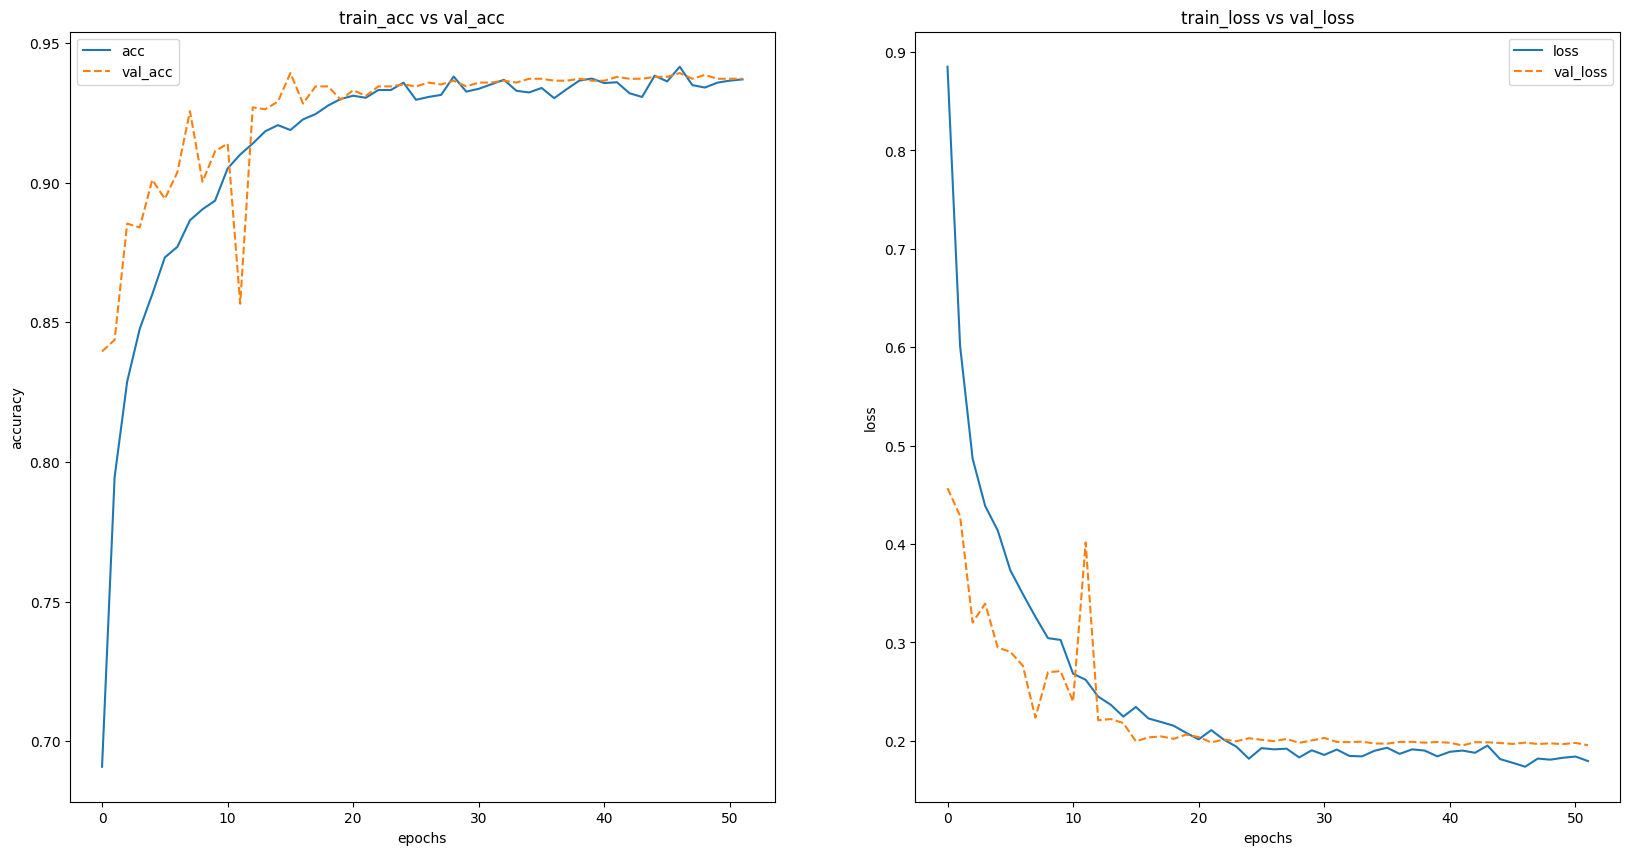

In [11]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(20,10))

    # Plot accuracy
    plt.subplot(121)
    plt.plot(history.history['accuracy'],'-', label = "acc")
    plt.plot(history.history['val_accuracy'], '--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(122)
    plt.plot(history.history['loss'],'-', label = "loss")
    plt.plot(history.history['val_loss'], '--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()
plot_accuracy_loss(history) 

In [12]:
model = keras.models.load_model('best_model.h5')
predictions = model.predict(test_generator)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

46/46 ━━━━━━━━━━━━━━━━━━━━ 26s 554ms/step


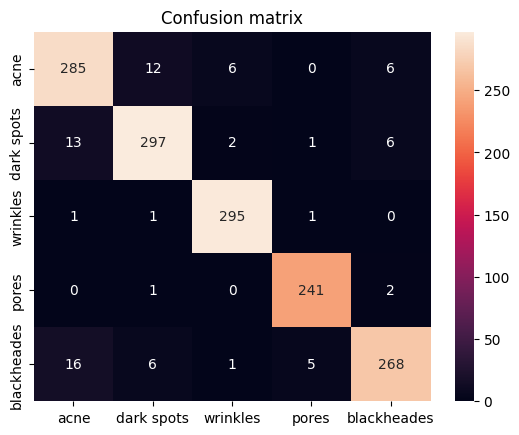

In [14]:
CM = confusion_matrix(Test_Labels, pred_labels)
ax = plt.axes()
sns.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels = Class_Names, 
           yticklabels = Class_Names,
           ax = ax,           
           fmt='d')
ax.set_title('Confusion matrix')
plt.show()

In [15]:
print(classification_report(Test_Labels, pred_labels,target_names = Class_Names))

              precision    recall  f1-score   support

        acne       0.90      0.92      0.91       309
  dark spots       0.94      0.93      0.93       319
    wrinkles       0.97      0.99      0.98       298
       pores       0.97      0.99      0.98       244
 blackheades       0.95      0.91      0.93       296

    accuracy                           0.95      1466
   macro avg       0.95      0.95      0.95      1466
weighted avg       0.95      0.95      0.95      1466



<div style="background-color:black;
            color:white;
            transform:skew(-20deg);
            padding:30px;
            font-family:Verdana;
            letter-spacing:1px;
            margin:auto;
            width:fit-content;">
    <h2 style="transform:skew(20deg); margin:0;">Prediction</h2>
</div>



In [2]:
model = keras.models.load_model("best_model.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
Predicted Class: acne
Confidence: 88.85 %


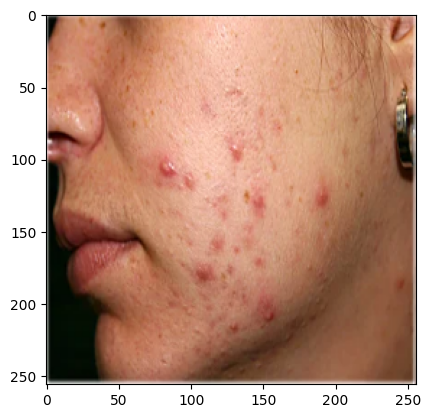

In [3]:
from tensorflow.keras.preprocessing import image
img_path = "Acne-and-Hormones.webp"
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Predict
pred = model.predict(img_array)
Class_Names = ['acne', 'dark spots', 'wrinkles', 'pores', 'blackheades']
print("Predicted Class:", Class_Names[np.argmax(pred)])
print("Confidence:", round(np.max(pred) * 100, 2), "%")

image = cv2.imread('Acne-and-Hormones.webp')
image = cv2.resize(image, (256, 256))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Predicted Class: pores
Confidence: 99.95 %


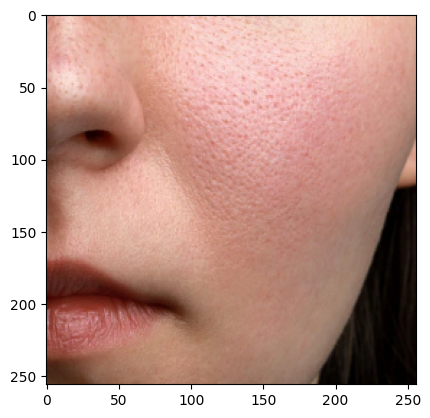

In [4]:
from tensorflow.keras.preprocessing import image
img_path = "Dilated_pores_in_greasy_skin_400x400.jpg.webp"
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Predict
pred = model.predict(img_array)
Class_Names = ['acne', 'dark spots', 'wrinkles', 'pores', 'blackheades']
print("Predicted Class:", Class_Names[np.argmax(pred)])
print("Confidence:", round(np.max(pred) * 100, 2), "%")

image = cv2.imread('Dilated_pores_in_greasy_skin_400x400.jpg.webp')
image = cv2.resize(image, (256, 256))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Predicted Class: dark spots
Confidence: 89.22 %


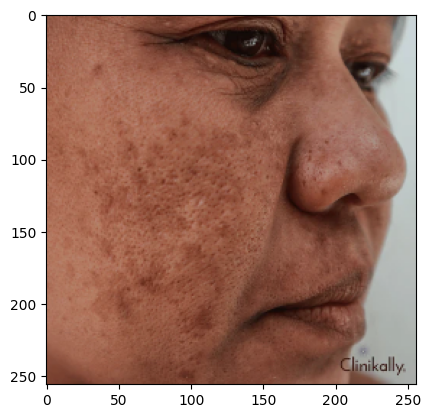

In [29]:
from tensorflow.keras.preprocessing import image
img_path = "163_5194f8e5-ae5c-4fd0-99e3-cfda286ae66f_480x480.webp"
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Predict
pred = model.predict(img_array)
Class_Names = ['acne', 'dark spots', 'wrinkles', 'pores', 'blackheades']
print("Predicted Class:", Class_Names[np.argmax(pred)])
print("Confidence:", round(np.max(pred) * 100, 2), "%")

image = cv2.imread('163_5194f8e5-ae5c-4fd0-99e3-cfda286ae66f_480x480.webp')
image = cv2.resize(image, (256, 256))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Predicted Class: blackheades
Confidence: 92.19 %


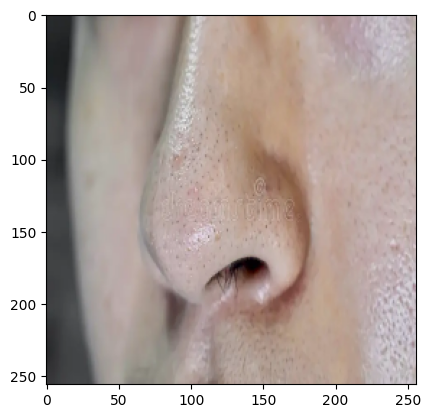

In [ ]:
from tensorflow.keras.preprocessing import image
img_path = "blackheads-black-heads-nose-asian-man-small-bumps-appear-skin-due-to-clogged-hair-follicles-closeup-view-191068177.webp"
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Predict
pred = model.predict(img_array)
Class_Names = ['acne', 'dark spots', 'wrinkles', 'pores', 'blackheades']
print("Predicted Class:", Class_Names[np.argmax(pred)])
print("Confidence:", round(np.max(pred) * 100, 2), "%")

image = cv2.imread('blackheads-black-heads-nose-asian-man-small-bumps-appear-skin-due-to-clogged-hair-follicles-closeup-view-191068177.webp')
image = cv2.resize(image, (256, 256))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Predicted Class: wrinkles
Confidence: 99.36 %


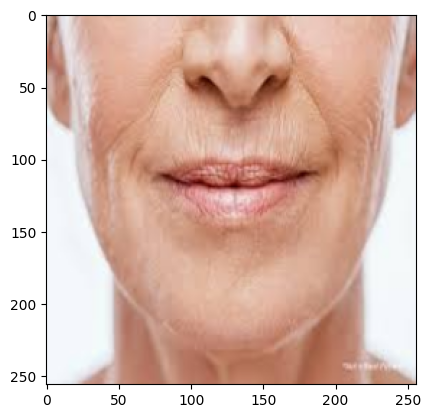

In [34]:
from tensorflow.keras.preprocessing import image
img_path = "images.jpg"
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Predict
pred = model.predict(img_array)
Class_Names = ['acne', 'dark spots', 'wrinkles', 'pores', 'blackheades']
print("Predicted Class:", Class_Names[np.argmax(pred)])
print("Confidence:", round(np.max(pred) * 100, 2), "%")

image = cv2.imread('images.jpg')
image = cv2.resize(image, (256, 256))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Predicted Class: wrinkles
Confidence: 99.91 %


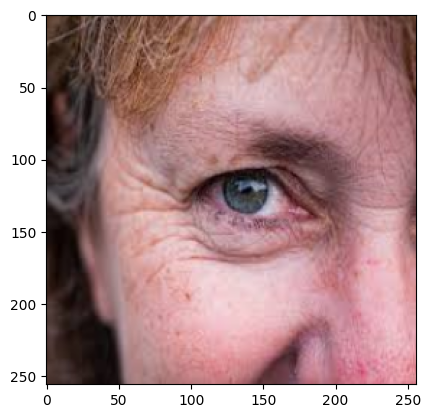

In [33]:
from tensorflow.keras.preprocessing import image
img_path = "images (1).jpg"
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Predict
pred = model.predict(img_array)
Class_Names = ['acne', 'dark spots', 'wrinkles', 'pores', 'blackheades']
print("Predicted Class:", Class_Names[np.argmax(pred)])
print("Confidence:", round(np.max(pred) * 100, 2), "%")

image = cv2.imread('images (1).jpg')
image = cv2.resize(image, (256, 256))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)